In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip freeze > /content/drive/MyDrive/Sheet_Music_ML/requirements.txt

# 1.0 YOLO

In [ ]:
!pip install ultralytics==8.0.117

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 16.1 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
YOLO_model = YOLO('/content/drive/MyDrive/Sheet_Music_ML/sheet-music/models/yolo/2024-09-27_01-40-26/weights/best.pt')

In [ ]:
def remove_highlights(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab_img)

    threshold = 5 # Smaller threshold <-> less lenient
    mask = cv2.inRange(A, 128-threshold, 128+threshold) & cv2.inRange(B, 128 - threshold, 128 + threshold)

    # Invert mask to get non-gray areas
    mask_inv = cv2.bitwise_not(mask)
    gray_image_colored = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    result = cv2.bitwise_and(img, img, mask=mask) + cv2.bitwise_and(gray_image_colored, gray_image_colored, mask=mask_inv)

    return result

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results


def predict_and_detect(chosen_model, img, classes=[], conf=0.5):
    results = predict(chosen_model, img, classes, conf=conf)
    cropped_images = []
    cropped_bars = []

    for result in results:
        for box in result.boxes:
            if int(box.cls[0]) == 0: # Class 2: line
              x1,x2,y1,y2 = int(box.xyxy[0][0]),int(box.xyxy[0][2]),int(box.xyxy[0][1]),int(box.xyxy[0][3])
              cropped_img = img[y1:y2, x1:x2]
              colors_removed_img = remove_highlights(cropped_img)
              cropped_images.append(colors_removed_img)

            # if int(box.cls[0]) == 1: # Class 1: bar
            #   x1,x2,y1,y2 = int(box.xyxy[0][0]),int(box.xyxy[0][2]),int(box.xyxy[0][1]),int(box.xyxy[0][3])
            #   cropped_bar = img[y1:y2, x1:x1]
            #   cropped_bars.append(cropped_bar)

            if int(box.cls[0]) == 1: # Class 1: bar
              x1, x2 = int(box.xyxy[0][0]), int(box.xyxy[0][2])
              cropped_bars.append((x1, x2))

    # return img, results, cropped_images, cropped_bars
    return cropped_images, cropped_bars

# defining function for creating a writer (for mp4 videos)

def create_video_writer(video_cap, output_filename):
    # grab the width, height, and fps of the frames in the video stream.
    frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_cap.get(cv2.CAP_PROP_FPS))

    # initialize the FourCC and a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_filename, fourcc, fps,
                             (frame_width, frame_height))

    return writer

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

video_path = "/content/y2mate.com - Goodbye To Romance  Ozzy Osbourne  Fingerstyle Guitar  Tabs  Chords  Lyrics_v720P.mp4"

cap = cv2.VideoCapture(video_path)

output_filename = "output"
writer = create_video_writer(cap, output_filename)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_interval = 3 * fps

frame_count = 0

sheet_music_lines = []
bar_lines = []

while True:

    success, img = cap.read()

    if not success:
        break

    if frame_count % frame_interval == 0:
      cropped_images, cropped_bars = predict_and_detect(YOLO_model, img, classes=[], conf=0.5)

      if len(cropped_images) > 1:  # There should only be 1 line of music per frame
            max_width = 0
            max_width_image = None

            for cropped_img in cropped_images:
                height, width = cropped_img.shape[:2]
                if width > max_width:
                    max_width = width
                    max_width_image = cropped_img

            cropped_images = [max_width_image]

      if len(cropped_images) != 0:
        sheet_music_lines.append(cropped_images[0])
        bars = []
        for bar in cropped_bars:
            bars.append(bar[1])

        bar_lines.append(bars)

    frame_count += 1
    # cv2.waitKey(1)

writer.release()

assert len(bar_lines) == len(sheet_music_lines)


0: 384x640 (no detections), 213.9ms
Speed: 7.6ms preprocess, 213.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 6 bars, 259.6ms
Speed: 4.7ms preprocess, 259.6ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 5 bars, 140.1ms
Speed: 4.4ms preprocess, 140.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 5 bars, 210.6ms
Speed: 3.0ms preprocess, 210.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 5 bars, 210.5ms
Speed: 5.4ms preprocess, 210.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 5 bars, 206.3ms
Speed: 5.2ms preprocess, 206.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 sheet-music, 5 bars, 187.6ms
Speed: 3.8ms preprocess, 187.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 shee

# 2.0 Siamese

In [ ]:
# sheet_music_pairs_img = Image.fromarray(sheet_music_lines[0])
sheet_music_pairs = [
    (Image.fromarray(sheet_music_lines[i]), Image.fromarray(sheet_music_lines[i+1]))
    for i in range(len(sheet_music_lines) - 1)]

i = 0

# sheet_music_pairs = sheet_music_pairs[0:50]

for img1, img2 in sheet_music_pairs:
  print(i)
  i += 1
  plt.imshow(np.array(img1))
  plt.axis('off')
  plt.show()
  plt.imshow(np.array(img2))
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
change_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15]
offset = 9

In [ ]:
for i in range(len(sheet_music_pairs)):
  if i + offset < 10:
    folder_path = '/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/000' + str(i+offset)
  elif i + offset < 100:
    folder_path = '/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/00' + str(i+offset)
  elif i + offset < 1000:
    folder_path = '/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0' + str(i+offset)
  else:
    folder_path = '/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/' + str(i+offset)

  os.makedirs(folder_path, exist_ok=True)

  print(folder_path)

  if i in change_indices:
    with open(folder_path + '/label.txt', 'w') as file:
      file.write("1")
  else:
    with open(folder_path + '/label.txt', 'w') as file:
      file.write("0")

  save_path_1 = folder_path + '/img1.png'
  save_path_2 = folder_path + '/img2.png'
  sheet_music_pairs[i][0].save(save_path_1)
  sheet_music_pairs[i][1].save(save_path_2)

/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0954
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0955
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0956
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0957
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0958
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0959
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0960
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0961
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0962
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0963
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0964
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0965
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0966
/content/drive/MyDrive/Sheet Music ML/sheet-music/siamese_dataset/0967
/conte

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.resnet = models.resnet18(pretrained=True)
    self.resnet.fc = nn.Identity() # Remove classification head

    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, 64)

  def forward_one(self, x):
    x = self.resnet(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def forward(self, input1, input2):
    output1 = self.forward_one(input1)
    output2 = self.forward_one(input2)
    return output1, output2

class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [ ]:
siamese_model = SiameseNetwork()
siamese_model.load_state_dict(torch.load('/content/drive/MyDrive/Sheet_Music_ML/sheet-music/models/siamese/2024-09-29_05-10-50.pt', map_location=torch.device('cpu')))
siamese_model.eval()

<ipython-input-17-0f1364591348>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_model.load_state_dict(torch.load('/content/drive/MyDrive/Sheet_Music_ML/sheet-music/

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])  # Same as ImageNet
                                ])

# plt.imshow(np.array(sheet_music_pairs[0][0]))
# plt.show()

unique_lines = []
unique_lines.append(sheet_music_pairs[0][0])

for (img1, img2) in sheet_music_pairs:
  img_tensor_1 = transform(img1)
  img_tensor_2 = transform(img2)

  output1, output2 = siamese_model(img_tensor_1.unsqueeze(0), img_tensor_2.unsqueeze(0))

  distance = F.pairwise_distance(output1, output2).item()

  if distance < 0.7:
      print("Images are similar ", distance)
      plt.imshow(np.array(img1))
      plt.show()
      plt.imshow(np.array(img2))
      plt.show()
  else:
      print("Images are different", distance)
      plt.imshow(np.array(img1))
      plt.show()
      plt.imshow(np.array(img2))
      plt.show()
      unique_lines.append(img2)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for line in unique_lines:
  plt.imshow(np.array(line))
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 3.0 ORB for sliding window


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# For sliding

def detect_and_compute(image):
  orb = cv2.ORB_create(
      nfeatures=10000,
      scaleFactor=1.05,
      nlevels=6,
      edgeThreshold=0,
      firstLevel=0,
      WTA_K=4,
      scoreType=cv2.ORB_FAST_SCORE,
      patchSize=31,
      fastThreshold=10
  )
  keypoints, descriptors = orb.detectAndCompute(image, None)
  return keypoints, descriptors

def draw_keypoints(image, keypoints):
  image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(image_with_keypoints)
  img2 = cv2.drawKeypoints(image, keypoints, None, color=(0,255,0), flags=0)
  cv2_imshow(img2)

def match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2, img1_shape, img2_shape):
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  initial_matches = matcher.match(descriptors1, descriptors2)

  biased_matches = []

  for initial_match in initial_matches:
    kp1 = keypoints1[initial_match.queryIdx].pt
    kp2 = keypoints2[initial_match.trainIdx].pt

    # keypoint indices: x: 0, y:1
    # img_shape indices: x: 1, y: 0
    kp1x, kp2x = kp1[0], kp2[0]
    kp2x = kp2

    x1_displacement = (img1_shape[1] - kp1[0]) / img1_shape[1]  # distance of keypoint 1 from the right end of image 1
    x2_displacement = kp2[0] / img2_shape[1]                    # distance of keypoint 2 from the left end of image 2

    # This is baseline distance between descriptors
    # For orb, maximum distance is 256 --> use for normalization
    descriptor_distance = initial_match.distance / 256

    initial_match.distance = x1_displacement + x2_displacement + 7 * descriptor_distance
    biased_matches.append(initial_match)

  biased_matches = sorted(biased_matches, key=lambda x: x.distance)
  return biased_matches

  # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  # matches = matcher.match(descriptors1, descriptors2)
  # matches = sorted(matches, key=lambda x: x.distance)
  # return matches

def draw_matches(image1, image2, keypoints1, keypoints2, matches):
  image_with_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
  cv2_imshow(image_with_matches)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

def find_homography_and_check_overlap(image1, image2, keypoints1, keypoints2, matches):
    if len(matches) < 4:
        print("Not enough matches to compute homography.")
        return None # Return None instead of False

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

    if H is not None:
        return H # Return the homography matrix
    else:
        return None # Return None instead of False

def get_transformed_corners(image_shape, H):
    h, w, = image_shape[:2]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)
    return transformed_corners

def compute_bounding_box(corners):
    x_coords, y_coords = zip(*[pt[0] for pt in corners])
    x_max = int(max(x_coords))
    x_min = 0
    y_min = 0
    y_max = int(max(y_coords))
    return (x_min, y_min), (x_max, y_max)

def draw_bounding_box(image, bbox):
    (x_min, y_min), (x_max, y_max) = bbox
    output_image = image.copy()
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    return output_image

def draw_axis_lines(image, x1, x2):
    output_image = image.copy()
    cv2.line(output_image, (x1, 10), (x2, 10), (0, 0, 255), 2)
    return output_image

In [ ]:
for image in sheet_music_lines:
  keypoints, descriptors = detect_and_compute(image)

The images have overlapping regions.


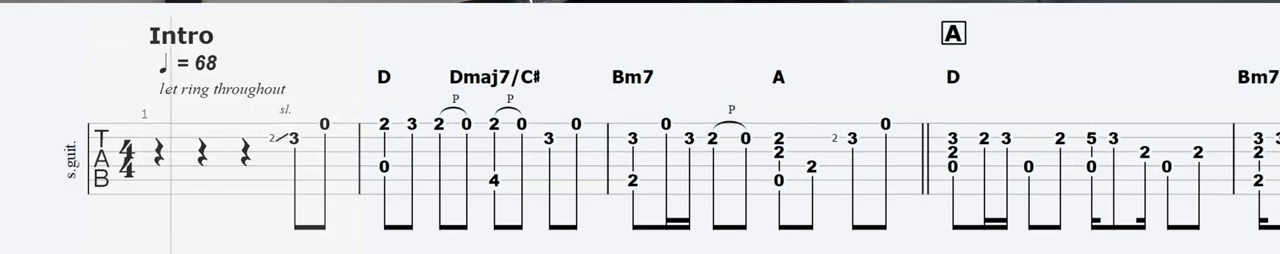

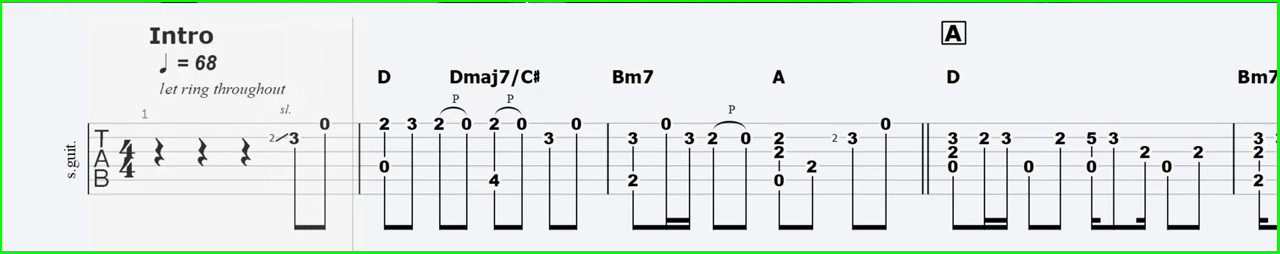

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [ ]:
unique_music = []
unique_music.append(sheet_music_lines[0])

sheet_music_pairs = [
    (sheet_music_lines[i], sheet_music_lines[i+1])
    for i in range(len(sheet_music_lines) - 1)]

bars_idx = 1

for (img1, img2) in sheet_music_pairs:
  keypoints1, descriptors1 = detect_and_compute(np.array(img1))
  keypoints2, descriptors2 = detect_and_compute(np.array(img2))
  matches = match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2, img1.shape, img2.shape)
  good_matches = matches[:int(len(matches) * 0.25)]

  homography_matrix = find_homography_and_check_overlap(img1, img2, keypoints1, keypoints2, good_matches) # Assign result to homography_matrix
  if homography_matrix is not None: # Check if homography_matrix is not None
      print("The images have overlapping regions.")
  else:
      print("The images do not have overlapping regions.")

  if homography_matrix is not None: # Check if homography_matrix is not None
    transformed_corners = get_transformed_corners(img1.shape, homography_matrix) # Use homography_matrix
    bbox = compute_bounding_box(transformed_corners)
    image_with_bbox = draw_bounding_box(img2, bbox)

    # Add cropped non-overlapping part of second image to array
    (x1, y1), (x2, y2) = bbox

    if abs(x2 - x1) < 0.8 * img2.shape[1]:
      unique_music.append(img2[y1:y2, x2:img2.shape[1]])

    cv2_imshow(img1)
    cv2_imshow(image_with_bbox)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


# 4.0 Plot sliding window

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def display_image_at_actual_size(image, save_path=None):
    """
    Display an image in its original size using plt.imshow(). Optionally save it as a PDF page.
    """
    h, w = image.shape[:2]
    dpi = plt.rcParams['figure.dpi']  # Use current DPI setting of matplotlib
    figsize = w / dpi, h / dpi  # Calculate the figure size in inches
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.axis('off')  # Turn off axis
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding around the image

    if save_path:
        fig.savefig(save_path, format='pdf')
    plt.close(fig)

def pad_image_to_height(image, target_height):
    """
    Pads the image vertically to match the target height.
    """
    h, w = image.shape[:2]
    if h == target_height:
        return image

    # Calculate padding
    pad_height = target_height - h
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    # Pad the image using np.pad
    padded_image = np.pad(image, ((pad_top, pad_bottom), (0, 0), (0, 0)), mode='constant', constant_values=255)
    return padded_image

def pad_image_to_width(image, target_width, align_left=True):
    """
    Pads the image horizontally to match the target width.
    If `align_left` is True, pads only on the right side to align the image to the left.
    """
    h, w = image.shape[:2]
    pad_width = target_width - w

    if pad_width <= 0:
        return image  # No padding needed

    if align_left:
        # Padding only on the right side
        pad_left = 0
        pad_right = pad_width
    else:
        # Padding equally on both sides
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

    padded_image = np.pad(image, ((0, 0), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=255)
    return padded_image

def crop_image_top_bottom(image, pixels=5):
    """Crop a specified number of pixels from the top and bottom of the image."""
    h, w = image.shape[:2]
    return image[pixels:h-pixels, :]  # Slice the image to remove `pixels` from top and bottom

def crop_image_width(image, crop_width):
    """Crop an image to a specified width."""
    return image[:, :crop_width]  # Keep only the first `crop_width` columns

def add_margin(image, margin):
    """
    Add a white margin around the image.
    """
    h, w = image.shape[:2]
    return np.pad(image, ((margin, margin), (margin, margin), (0, 0)), mode='constant', constant_values=255)

def stitch_and_save_images_to_pdf(unique_music, pdf_file_path, width_threshold=int(plt.rcParams['figure.dpi'] * 8.5), height_threshold=int(plt.rcParams['figure.dpi'] * 11), align_left=True, margin=10):
    """
    Stitch images together, and save each stitched result as a page in a PDF.
    """
    stitched_row = []
    stitched_rows = []  # Store all rows to stack vertically
    current_width = 0  # Track the current width of the stitched images
    current_height = 0  # Track the current height of the stitched rows
    max_row_height = 0  # Track the height of the tallest image in the row
    max_row_width = 0  # Track the width of the widest row

    pdf_pages = PdfPages(pdf_file_path)

    for line in unique_music:
        line_np = np.array(line)  # Convert to NumPy array if needed
        h, w = line_np.shape[:2]  # Get the height and width of the current image

        # If adding the next image will exceed the width threshold, handle the current row
        if current_width + w > width_threshold:
            remaining_width = width_threshold - current_width
            cropped_image = crop_image_width(line_np, remaining_width)
            stitched_row.append(cropped_image)

            # Pad all images in the row to match the height of the tallest image
            max_row_height = max(img.shape[0] for img in stitched_row)
            padded_row = [pad_image_to_height(img, max_row_height) for img in stitched_row]
            stitched_row_img = np.hstack(padded_row)
            stitched_row_img = crop_image_top_bottom(stitched_row_img)
            stitched_rows.append(stitched_row_img)

            # Update the total width of the stitched image (for padding rows)
            max_row_width = max(max_row_width, stitched_row_img.shape[1])
            current_height += max_row_height

            # Check if the current height exceeds the height threshold
            if current_height > height_threshold:
                # Pad all rows to the same width, aligning to the left if specified
                padded_rows = [pad_image_to_width(row, max_row_width, align_left=align_left) for row in stitched_rows]
                stitched_image = np.vstack(padded_rows)

                # Add margins around the entire stitched image
                stitched_image_with_margin = add_margin(stitched_image, 100)

                # Display and save the image with margins
                display_image_at_actual_size(stitched_image_with_margin, save_path=pdf_pages)

                # Reset for the next set of rows
                stitched_rows = []
                current_height = 0

            # Reset for the next row with the remaining portion of the image
            stitched_row = [line_np[:, remaining_width:]]  # Remaining part of the current image
            current_width = w - remaining_width
            max_row_height = h
        else:
            # Add the image to the current row
            stitched_row.append(line_np)
            current_width += w
            max_row_height = max(max_row_height, h)  # Update the tallest image in the row

    # Handle any remaining images in the last row
    if stitched_row:
        max_row_height = max(img.shape[0] for img in stitched_row)  # Ensure height consistency
        padded_row = [pad_image_to_height(img, max_row_height) for img in stitched_row]
        stitched_row_img = np.hstack(padded_row)
        stitched_rows.append(stitched_row_img)

    # Display and save any remaining stitched rows if they don't reach the height threshold
    if stitched_rows:
        # Pad all rows to the same width before stacking, aligning to the left if specified
        max_row_width = max(row.shape[1] for row in stitched_rows)  # Get max width again
        padded_rows = [pad_image_to_width(row, max_row_width, align_left=align_left) for row in stitched_rows]
        stitched_image = np.vstack(padded_rows)

        # Add margins around the entire stitched image
        stitched_image_with_margin = add_margin(stitched_image, margin)

        # Display and save the image with margins
        display_image_at_actual_size(stitched_image_with_margin, save_path=pdf_pages)

    pdf_pages.close()


In [ ]:
stitch_and_save_images_to_pdf(unique_music=unique_music, pdf_file_path='output.pdf', align_left=True)

# 4.0 ORB for unique images


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# For sliding

def detect_and_compute(image):
  orb = cv2.ORB_create(
      nfeatures=20000,
      scaleFactor=1.2,
      nlevels=6,
      edgeThreshold=0,
      firstLevel=0,
      WTA_K=4,
      scoreType=cv2.ORB_FAST_SCORE,
      patchSize=31,
      fastThreshold=30
  )
  keypoints, descriptors = orb.detectAndCompute(image, None)
  return keypoints, descriptors

def draw_keypoints(image, keypoints):
  image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(image_with_keypoints)
  img2 = cv2.drawKeypoints(image, keypoints, None, color=(0,255,0), flags=0)
  cv2_imshow(img2)

def match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2, img1_shape, img2_shape):
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = matcher.match(descriptors1, descriptors2)
  matches = sorted(matches, key=lambda x: x.distance)
  return matches

def draw_matches(image1, image2, keypoints1, keypoints2, matches):
  image_with_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
  cv2_imshow(image_with_matches)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

# def are_images_same(image1, image2, keypoints1, keypoints2, matches, match_threshold=25, min_matches=2500):
#     # Calculate total distance and average distance of matches
#     total_distance = sum([m.distance for m in matches])
#     avg_distance = total_distance / len(matches) if len(matches) > 0 else float('inf')

#     print(f"Number of Matches: {len(matches)}")
#     print(f"Average Distance: {avg_distance}")
#     # Determine if images are the same based on the number of matches and average match distance
#     if len(matches) >= min_matches and avg_distance <= match_threshold:
#         return True
#     else:
#         return False

def are_images_same(image1, image2, keypoints1, keypoints2, matches, match_threshold=3, min_matches=0):
    """
    Determine if two images are the same based on horizontal x-coordinate distances of matched keypoints.
    """
    # Calculate total horizontal distance of matches, ignoring y distances
    total_distance = 0
    for m in matches:
        # Retrieve the matched keypoints from both images
        kp1 = keypoints1[m.queryIdx].pt  # (x1, y1)
        kp2 = keypoints2[m.trainIdx].pt  # (x2, y2)

        # Compute absolute x-distance between the matched keypoints
        x_distance = abs(kp2[0] - kp1[0])  # Ignore y-coordinate
        total_distance += x_distance

    avg_distance = total_distance / len(matches) if len(matches) > 0 else float('inf')

    print(f"Number of Matches: {len(matches)}")
    print(f"Average X Distance: {avg_distance}")

    # Determine if images are the same based on the number of matches and average horizontal distance
    if len(matches) >= min_matches and avg_distance <= match_threshold:
        return True
    else:
        return False

In [ ]:
for image in sheet_music_lines:
  keypoints, descriptors = detect_and_compute(image)

In [ ]:
unique_music = []
unique_music.append(sheet_music_lines[0])

sheet_music_pairs = [
    (sheet_music_lines[i], sheet_music_lines[i+1])
    for i in range(len(sheet_music_lines) - 1)]

bars_idx = 1

for (img1, img2) in sheet_music_pairs:
  keypoints1, descriptors1 = detect_and_compute(np.array(img1))
  keypoints2, descriptors2 = detect_and_compute(np.array(img2))
  matches = match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2, img1.shape, img2.shape)
  good_matches = matches[:int(len(matches) * 0.25)]
  # print(f"Matches: {len(good_matches)}")

  if are_images_same(img1, img2, keypoints1, keypoints2, good_matches):
      print("Images are the same.")
  else:
      print("Images are different.")
      unique_music.append(img2)

  cv2_imshow(img1)
  cv2_imshow(img2)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

sheet_music_pairs = [
    (unique_music[i], unique_music[i+1])
    for i in range(len(unique_music) - 1)]

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])  # Same as ImageNet
                                ])

# plt.imshow(np.array(sheet_music_pairs[0][0]))
# plt.show()

unique_lines = []
unique_lines.append(sheet_music_pairs[0][0])

for (img1, img2) in sheet_music_pairs:
  img1 = Image.fromarray(np.array(img1))
  img2 = Image.fromarray(np.array(img2))
  img_tensor_1 = transform(img1)
  img_tensor_2 = transform(img2)

  output1, output2 = siamese_model(img_tensor_1.unsqueeze(0), img_tensor_2.unsqueeze(0))

  distance = F.pairwise_distance(output1, output2).item()

  if distance < 0.7:
      print("Images are similar ", distance)
      plt.imshow(np.array(img1))
      plt.show()
      plt.imshow(np.array(img2))
      plt.show()
  else:
      print("Images are different", distance)
      plt.imshow(np.array(img1))
      plt.show()
      plt.imshow(np.array(img2))
      plt.show()
      unique_lines.append(img2)


# 6.0 Plot unique images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def display_image_at_actual_size(image, save_path=None):
    """
    Display an image in its original size using plt.imshow(). Optionally save it as a PDF page.
    """
    h, w = image.shape[:2]
    dpi = plt.rcParams['figure.dpi']  # Use current DPI setting of matplotlib
    figsize = w / dpi, h / dpi  # Calculate the figure size in inches
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.axis('off')  # Turn off axis
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding around the image

    if save_path:
        fig.savefig(save_path, format='pdf')
    plt.close(fig)

def pad_image_to_height(image, target_height):
    """
    Pads the image vertically to match the target height.
    """
    h, w = image.shape[:2]
    if h == target_height:
        return image

    # Calculate padding
    pad_height = target_height - h
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    # Pad the image using np.pad
    padded_image = np.pad(image, ((pad_top, pad_bottom), (0, 0), (0, 0)), mode='constant', constant_values=255)
    return padded_image

def pad_image_to_width(image, target_width):
    """
    Pads the image horizontally to match the target width.
    """
    h, w = image.shape[:2]
    if w == target_width:
        return image

    pad_width = target_width - w
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    padded_image = np.pad(image, ((0, 0), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=255)
    return padded_image

def crop_image_top_bottom(image, pixels=10):
    """Crop a specified number of pixels from the top and bottom of the image."""
    h, w = image.shape[:2]
    return image[pixels:h-pixels, :]  # Slice the image to remove `pixels` from top and bottom

def add_margin(image, margin):
    """
    Add a white margin around the image.
    """
    h, w = image.shape[:2]
    return np.pad(image, ((margin, margin), (margin, margin), (0, 0)), mode='constant', constant_values=255)

def stitch_and_save_images_to_pdf(unique_music, pdf_file_path, height_threshold=int(plt.rcParams['figure.dpi'] * 11), margin=10):
    """
    Stitch images together vertically and save each stitched result as a page in a PDF.
    """
    stitched_images = []  # Store all images to stack vertically
    current_height = 0  # Track the current height of the stitched images
    max_width = 0  # Track the width of the widest image

    pdf_pages = PdfPages(pdf_file_path)

    for image in unique_music:
        line_np = np.array(image)  # Convert to NumPy array if needed
        h, w = line_np.shape[:2]  # Get the height and width of the current image

        # If adding the next image will exceed the height threshold, handle the current images
        if current_height + h > height_threshold:
            # Pad all images in the current stack to match the width of the widest image
            max_width = max(img.shape[1] for img in stitched_images)
            padded_images = [pad_image_to_width(img, max_width) for img in stitched_images]
            stitched_image = np.vstack(padded_images)

            # Add margins around the entire stitched image
            stitched_image_with_margin = add_margin(stitched_image, margin)

            # Display and save the image with margins
            display_image_at_actual_size(stitched_image_with_margin, save_path=pdf_pages)

            # Reset for the next set of images
            stitched_images = []
            current_height = 0

        # Add the image to the current stack
        stitched_images.append(line_np)
        current_height += h
        max_width = max(max_width, w)  # Update the maximum width

    # Handle any remaining images in the last stack
    if stitched_images:
        # Pad all images to the same width before stacking
        max_width = max(img.shape[1] for img in stitched_images)  # Get max width again
        padded_images = [pad_image_to_width(img, max_width) for img in stitched_images]
        stitched_image = np.vstack(padded_images)

        # Add margins around the entire stitched image
        stitched_image_with_margin = add_margin(stitched_image, margin)

        # Display and save the image with margins
        display_image_at_actual_size(stitched_image_with_margin, save_path=pdf_pages)

    pdf_pages.close()



In [ ]:
stitch_and_save_images_to_pdf(unique_music=unique_lines, pdf_file_path='output.pdf')